## Introduction
###Challenge Goal 
Optimizing conversion rates is one of the most important tasks of a data scientist.

This is why, we will build a model that will predict the conversion rate of customers on a website and will make recommendations to our marketing team to be able to increase our revenues.

###Description of the challenge
We have collected data from users of the website of a public limited company. Your project consists of:
Create a conversion rate prediction model (will the user convert or not).
Find recommendations for the Product & Marketing team to improve this conversion rate.

### About the data:


## Table of Contents

I. [Overview of the dataset and simple-data-visualization](#cln)

II. [Data Cleaning and Modeling](#cln)

III. [Conclusion](#ccn)

In [12]:
# importing packages
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 1000 #handy for showing truncated results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

In [1]:
import pandas
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("https://drive.google.com/uc?export=download&id=1KvxyyF3QCtvIx0J7_8iWDEtFQpLgd0Yq")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


<a id="cln"> I.Simple-data-visualization-with-plotly.ipynb</a>






####Overview of the dataset

 

In [4]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [5]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [6]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


In [7]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [8]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


####It is just 2 users! In this case, we can remove them, nothing will change.

In [0]:
data = data[data['age']<110]

#### Now, let’s quickly investigate the variables and how their distribution differs for the two classes. This will help us understand whether there is any information in our data in the first place and get a sense of the data.

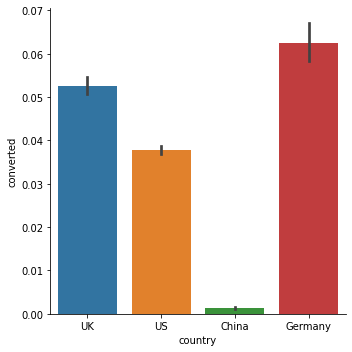

In [10]:
import seaborn as sns 
sns.catplot(x="country", y="converted", data=data, kind="bar")

####Here it clearly looks like Chinese convert at a much lower rate than other countries! 

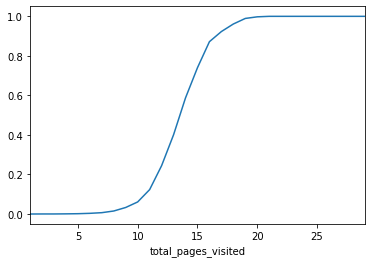

In [13]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

Definitely spending more time on the site implies higher probability of conversion!

<a id="cln">II.Data cleaning and Modeling</a>






#### Now let's build a model to predict the conversion rate.
I will choose a random forest to predict the conversion rate. I chose a random forest because: it generally takes very little time to optimize it (its default parameters are often close to being the best) and it is strong with outliers, irrelevant variables, variables continuous and discreet. I will use the random forest to predict conversion, then I will use its graphs of partial dependence and variable importance to obtain information. Also, I'm going to build a simple tree to find the most obvious user segments.
Firstly, let’s create dummy variables from the categorical ones.

In [0]:
#dummy variables for the categorical ones
data_dummy = pandas.get_dummies(data, drop_first=True)

I would cross-validate). Then, I build the forest with standard values ​​for the 3 important parameters (100 trees, trees as large as possible, 3 random variables selected at each fractionation).

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


In [17]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


 Thus, the OOB error and the test error are quite similar, ~ 1.5%. We are convinced that we do not adapt too much.

The error is quite small. However, we started with an accuracy of 97% (this is the case if we classify everything as "not converted"). So 98.5% is good, but nothing shocking. Indeed, ~ 30% of conversions are planned as "no
Let's start by checking the importance of the variables.

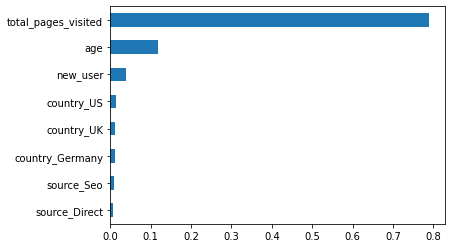

In [18]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

####The total number of pages visited is by far the largest. People visit many pages because they already want to buy. Let's reconstruct the RF without this variable.

In [20]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8903253629785807 
 OOB Confusion Matrix 
         0      1
0  182889  19085
1    3803   2913


In [21]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8917940990437921 
 Test Set Confusion Matrix 
        0     1
0  94358  9668
1   1965  1517


####The precision has dropped but the model is still good enough to give us an overview.Recheck the importance of the variables:

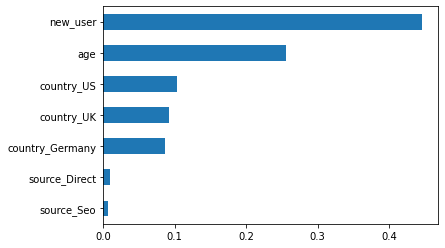

In [23]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

####The New User variable is the most important, even more important than age.
Let's check the partial dependency diagrams for the 4 variables.

     |████████████████████████████████| 57.7MB 73kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=f7f2fb66496daabede9c1e7eb9013ab11eaeec66f7ab79207ec5c76b74d1c5a0
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


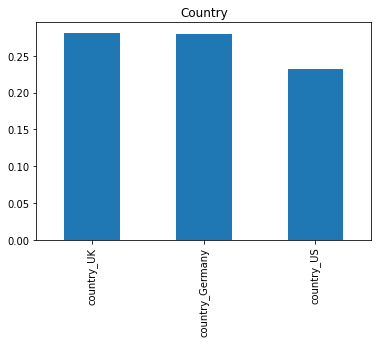

In [24]:
!pip install pdpbox
from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()


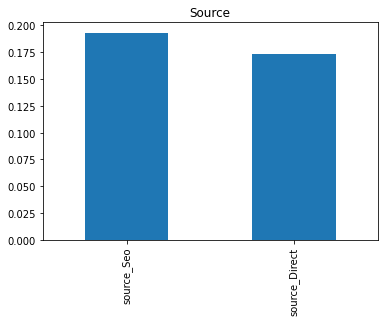

In [25]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

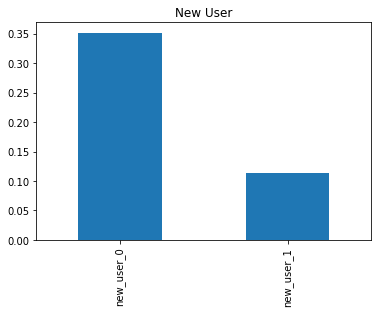

In [26]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()


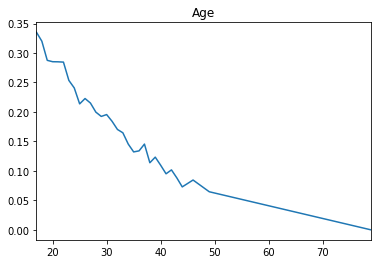

In [27]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

####Users with an old account are much better than new users.
Germany, the United Kingdom and the United States are similar, with Germany being the best. Most importantly, they all have very very high values. As usual, we have to read this from the baseline, which is China. So this means that not being from China and one of these 3 countries greatly increases the likelihood of conversion. In other words, China is very bad at conversion.
The site works very well for young people and gets worse for the elderly.
The source is less relevant
Now let's build a simple decision tree and check the 2 or 3 most important segments.

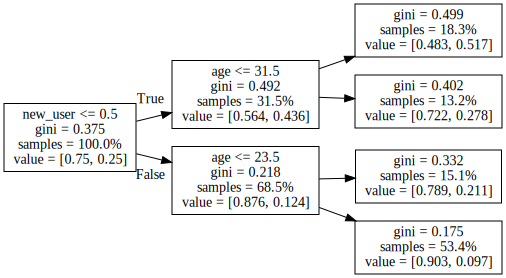

In [28]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
dot_data = export_graphviz(tree, out_file=None, feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
graph = graphviz.Source(dot_data)

graph

A simple small tree confirms exactly the random forest findings.

<a id="cln">CONCLUSION</a>


1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

4. Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

5. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity. 


As you can see, product ideas usually end up being about:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

Tell product to fix the experience for the bad performing ones

Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if you can guess why that’s happening and then build a test to validate your hypothesis


